In [4]:
import torch
import cv2
import numpy as np
import json
import pandas as pd
import seaborn as sns
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

### Load predicion dataset

In [160]:
#Takes about 20s

nframes = 181
nn_thresholds = [0.5,0.6,0.7,0.8]
area_pcgs = [0.5,0.6,0.7,0.8]
columns = ['x1','y1','x2','y2','classId','frame_number']
PRED_df = pd.DataFrame(columns = columns)

for nn_threshold in nn_thresholds:
    for area_pcg in area_pcgs:
        for i in np.arange(nframes)*10:
            filename = './Predictions/frame_%d(n=%d,a=%d).json' % (i,10*nn_threshold,10*area_pcg)
            new_df = pd.read_json(filename).T
            PRED_df = PRED_df.append(new_df, ignore_index = True)
PRED_df.frame_number = PRED_df.frame_number.astype(int)
PRED_df['classId'] = PRED_df['classId'].astype('str') 
PRED_df['Recognized'] = False
PRED_df

,x1,y1,x2,y2,classId,frame_number,NN_threshold,Area_percentage,Recognized
0,266.257416,77.200035,274.85498,84.262711,car,0,0.5,0.5,False
1,289.19577,67.997673,294.557465,73.147499,car,0,0.5,0.5,False
2,262.7435,88.04834,272.156616,96.14402,car,10,0.5,0.5,False
3,288.435028,78.584961,293.58374,83.529137,car,10,0.5,0.5,False
4,258.082947,85.552414,267.617157,94.478081,car,20,0.5,0.5,False
...,...,...,...,...,...,...,...,...,...
12547,433.171814,176.703537,481.944733,214.816376,car,1800,0.8,0.8,False
12548,364.967468,103.940979,375.95517,112.530533,car,1800,0.8,0.8,False
12549,278.101929,99.109917,285.191467,105.298286,car,1800,0.8,0.8,False
12550,290.205322,99.332993,296.702454,105.177734,car,1800,0.8,0.8,False


### Load ground-truth dataset

In [161]:
nframes = 181
class_dict = {1:'car', 2:'truck', 3:'no_class', 4:'bus'}
columns = ['x1','y1','x2','y2','classId','frame_number']
GT_df = pd.DataFrame(columns = columns)

for i in np.arange(nframes)*10:
    filename = './GroundTruth/frame_%d.jpg.json' % i 
    data = json.load(open(filename))
    if len(data["tags"]) == 0:
        L = len(data["instances"])
        dicts = []
        for j in range(L):
            mydict = {
                'x1' : data["instances"][j]["points"]["x1"],
                'y1' : data["instances"][j]["points"]["y1"],
                'x2' : data["instances"][j]["points"]["x2"],
                'y2' : data["instances"][j]["points"]["y2"],
                'classId' : class_dict[data["instances"][j]["classId"]],
                'frame_number' : i
            }
            dicts.append(mydict)
        new_df = pd.DataFrame.from_dict(dicts)
        GT_df = GT_df.append(new_df, ignore_index = True)
GT_df['frame_number'] = GT_df['frame_number'].astype(int)
GT_df['classId'] = GT_df['classId'].astype('str') 
GT_df

,x1,y1,x2,y2,classId,frame_number
0,249.141968,86.870743,266.399994,97.800003,car,30
1,236.600000,94.700000,253.000000,109.600000,car,50
2,228.000000,95.500000,247.600000,111.900000,car,60
3,213.924103,97.827415,236.600006,118.199997,car,70
4,541.058960,178.437210,600.000000,230.100006,car,70
...,...,...,...,...,...,...
348,387.665588,114.262421,404.100006,126.800003,truck,1750
349,382.200000,110.400000,395.500000,122.900000,truck,1760
350,481.579926,216.002930,559.799988,279.399994,car,1790
351,431.500000,176.900000,481.700000,216.600000,car,1800


## Performance evaluation

In [165]:
y_real = []
y_pred = []
best_a_pcg = 0.5
best_nn_th = 0.7


def compute_overlap(A, B, classif = False):    
    a_idx = A.index
    b_idx = B.index
    a_class = A.loc[a_idx,'classId'].values[0].strip()
    b_class = B.loc[b_idx,'classId'].values[0].strip()
    area_pcg = B['Area_percentage'].values[0]
    nn_th = B['NN_threshold'].values[0]
    XA1 = float(A['x1'])
    XA2 = float(A['x2'])
    YA1 = float(A['y1'])
    YA2 = float(A['y2'])
    XB1 = float(B['x1'])
    XB2 = float(B['x2'])
    YB1 = float(B['y1'])
    YB2 = float(B['y2'])
    A_area = abs(XA1-XA2)*abs(YA1-YA2)
    B_area = abs(XB1-XB2)*abs(YB1-YB2)
    overlap_area = max(0, min(XA2, XB2) - max(XA1, XB1)) * max(0, min(YA2, YB2) - max(YA1, YB1))
    IoU = overlap_area/(A_area + B_area - overlap_area)
    if IoU >= area_pcg:
        if classif:
            if round(10*area_pcg) == 10*best_a_pcg and round(10*nn_th) == 10*best_nn_th:
                y_real.append(a_class)
                y_pred.append(b_class)   
            if a_class==b_class:
                B.loc[b_idx,'Recognized'] = True
        else:
            B.loc[b_idx,'Recognized'] = True

def scoring_grouped_df(whole_gt_df, grouped_pred_df, classif = False):
    frame = grouped_pred_df['frame_number'].values[0]
    gt_df = whole_gt_df[whole_gt_df['frame_number']==frame]
    for i in gt_df.index:
        test_A = gt_df[gt_df.index == i]
        compute_overlap(test_A, grouped_pred_df, classif)
    return grouped_pred_df

def recall_normalization(p_df, gt_df):
    frame_num = int(p_df['frame_number'].values[0])
    g_df = gt_df[gt_df['frame_number']==frame_num]
    L = g_df.shape[0]
    if L != 0:
        return min(1,sum(p_df.Recognized)/L)
    else:
        return np.nan

#### Vehicle detection

In [166]:
#Takes 40s to compute
PRED_df['Recognized'] = False
PRED_df = PRED_df.groupby(PRED_df.index).apply(lambda row : scoring_grouped_df(GT_df, row, classif=False))

Recall = PRED_df.groupby(['NN_threshold','Area_percentage','frame_number']).apply(lambda x : recall_normalization(x, GT_df)).to_frame()
Recall = Recall.groupby(['NN_threshold','Area_percentage']).apply(lambda x : np.nanmean(x))
Recall = Recall.reset_index().pivot(columns='NN_threshold',index='Area_percentage',values=0)
Recall.columns = pd.Series([0.5,0.6,0.7,0.8], name = 'NN_threshold')
Recall.index = pd.Series([0.5,0.6,0.7,0.8], name = 'Area_percentage')

Precision = PRED_df.groupby(['NN_threshold','Area_percentage','frame_number']).apply(lambda x : sum(x.Recognized)/x.shape[0]).to_frame()
Precision = Precision.groupby(['NN_threshold','Area_percentage']).mean()
Precision = Precision.reset_index().pivot(columns='NN_threshold',index='Area_percentage',values=0)
Precision.columns = pd.Series([0.5,0.6,0.7,0.8], name = 'NN_threshold')
Precision.index = pd.Series([0.5,0.6,0.7,0.8], name = 'Area_percentage')

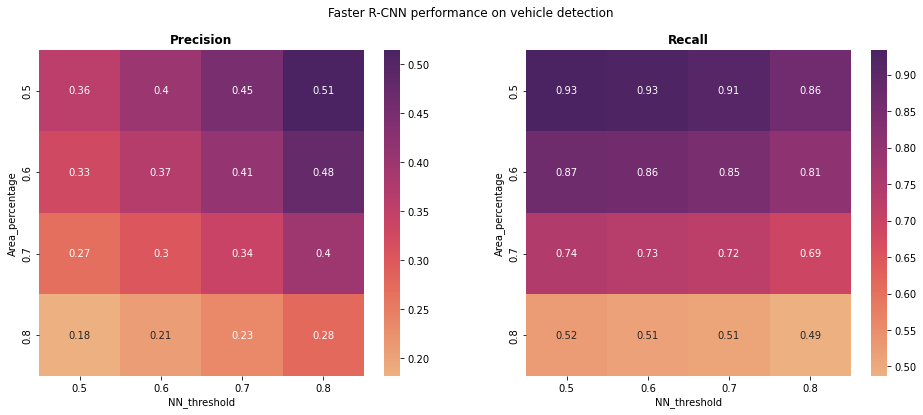

In [167]:
cmap = sns.color_palette("flare", as_cmap=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Faster R-CNN performance on vehicle detection')
sns.heatmap(Precision, annot=True, cmap=cmap, ax=ax1)
ax1.set_title('Precision',fontweight="bold")
sns.heatmap(Recall, annot=True, cmap=cmap, ax=ax2)
ax2.set_title('Recall',fontweight="bold")

plt.savefig('./Results/Total_results_detection.png')
plt.savefig('./Results/Total_results_detection.svg')
plt.show()

plt.close(fig)

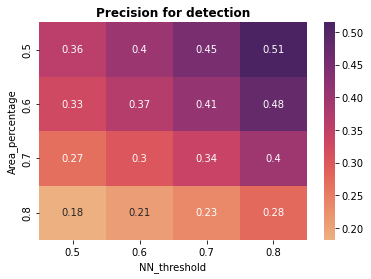

In [26]:
ax = plt.axes()
sns.heatmap(Precision, annot=True, cmap=cmap, ax=ax)
ax.set_title('Precision for detection', fontweight="bold")
plt.savefig('./Results/Precision_detection.png')
plt.savefig('./Results/Precision_detection.svg')
plt.show()

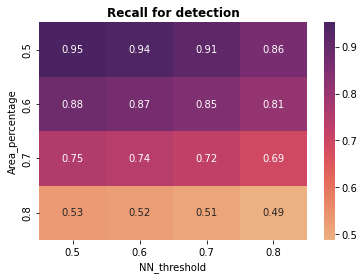

In [27]:
ax = plt.axes()
sns.heatmap(Recall, annot=True, cmap=cmap, ax=ax)
ax.set_title('Recall for detection', fontweight="bold")
plt.savefig('./Results/Recall_detection.png')
plt.savefig('./Results/Recall_detection.svg')
plt.show()

#### Vehicle classification

In [168]:
#Takes 40s to compute
PRED_df['Recognized'] = False
PRED_df = PRED_df.groupby(PRED_df.index).apply(lambda row : scoring_grouped_df(GT_df, row, classif=True))

Recall = PRED_df.groupby(['NN_threshold','Area_percentage','frame_number']).apply(lambda x : recall_normalization(x, GT_df)).to_frame()
Recall = Recall.groupby(['NN_threshold','Area_percentage']).apply(lambda x : np.nanmean(x))
Recall = Recall.reset_index().pivot(columns='NN_threshold',index='Area_percentage',values=0)
Recall.columns = pd.Series([0.5,0.6,0.7,0.8], name = 'NN_threshold')
Recall.index = pd.Series([0.5,0.6,0.7,0.8], name = 'Area_percentage')

Precision = PRED_df.groupby(['NN_threshold','Area_percentage','frame_number']).apply(lambda x : sum(x.Recognized)/x.shape[0]).to_frame()
Precision = Precision.groupby(['NN_threshold','Area_percentage']).mean()
Precision = Precision.reset_index().pivot(columns='NN_threshold',index='Area_percentage',values=0)
Precision.columns = pd.Series([0.5,0.6,0.7,0.8], name = 'NN_threshold')
Precision.index = pd.Series([0.5,0.6,0.7,0.8], name = 'Area_percentage')

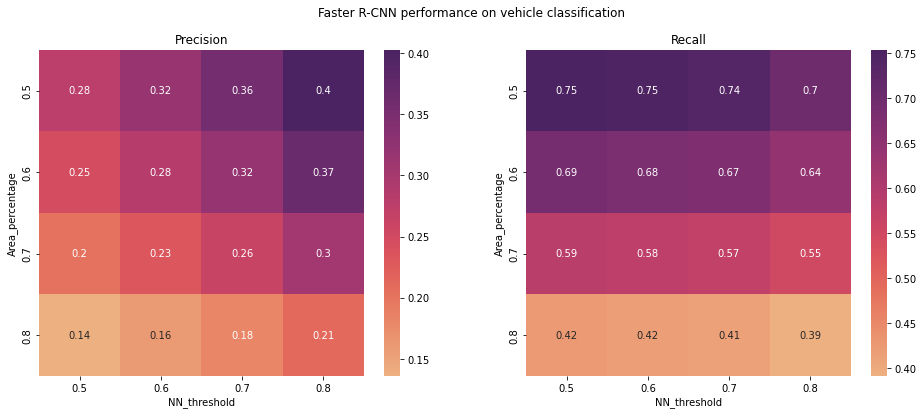

In [169]:
cmap = sns.color_palette("flare", as_cmap=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Faster R-CNN performance on vehicle classification')
sns.heatmap(Precision, annot=True, cmap=cmap, ax=ax1)
ax1.set_title('Precision')
sns.heatmap(Recall, annot=True, cmap=cmap, ax=ax2)
ax2.set_title('Recall')

plt.savefig('./Results/Total_results_classification.png')
plt.savefig('./Results/Total_results_classification.svg')
plt.show()
plt.close(fig)

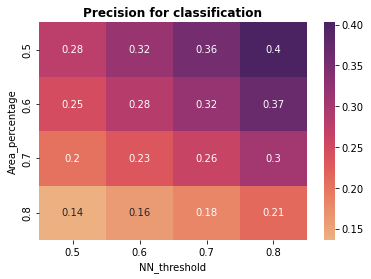

In [31]:
ax = plt.axes()
sns.heatmap(Precision, annot=True, cmap=cmap, ax=ax)
ax.set_title('Precision for classification', fontweight="bold")
plt.savefig('./Results/Precision_classification.png')
plt.savefig('./Results/Precision_classification.svg')
plt.show()

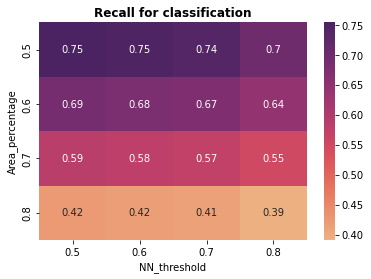

In [32]:
ax = plt.axes()
sns.heatmap(Recall, annot=True, cmap=cmap, ax=ax)
ax.set_title('Recall for classification', fontweight="bold")
plt.savefig('./Results/Recall_classification.png')
plt.savefig('./Results/Recall_classification.svg')
plt.show()

#### Confusion matrix for NN_th = 0.7

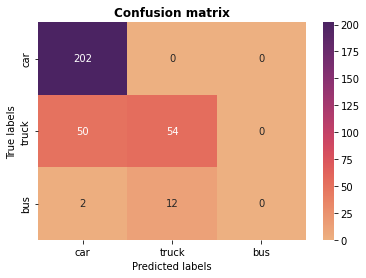

In [103]:
ax = plt.axes()
labels=["car", "truck", "bus"]
cm = confusion_matrix(y_real, y_pred, labels=labels, normalize = None)
sns.heatmap(cm, annot=True, cmap=cmap, fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
ax.set_title('Confusion matrix', fontweight="bold")
plt.savefig('./Results/CMatrix_07.png')
#plt.savefig('./Results/CMatrix_07.svg')
plt.show()

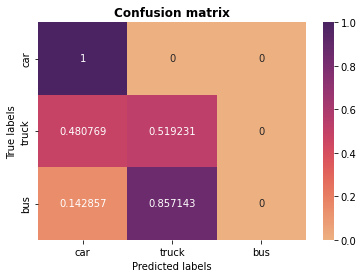

In [260]:
ax = plt.axes()
labels=["car", "truck", "bus"]
cm = confusion_matrix(y_real, y_pred, labels=labels, normalize = 'true')
sns.heatmap(cm, annot=True, cmap=cmap, fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
ax.set_title('Confusion matrix', fontweight="bold")
plt.savefig('./Results/CMatrix_07.png')
#plt.savefig('./Results/CMatrix_07.svg')
plt.show()

## Output video

In [256]:
def object_detection_api(img_path, video_writer, gt, pred, count, rect_th=3, text_size=3, text_th=3, plot = False, save = False, video = True):
    GT = gt[gt.frame_number == count]
    gt_boxes = GT[['x1','y1','x2','y2']]
    gt_cls = GT['classId']
    PRED = pred[pred.frame_number == count]
    pred_boxes = PRED[['x1','y1','x2','y2']]
    pred_cls = PRED['classId']
    # Get predictions
    img = cv2.imread(img_path)
    # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Convert to RGB
    for i in pred_boxes.index:
        x1 = round(pred_boxes.loc[i,'x1'])
        y1 = round(pred_boxes.loc[i,'y1'])
        x2 = round(pred_boxes.loc[i,'x2'])
        y2 = round(pred_boxes.loc[i,'y2'])
        cv2.rectangle(img, (x1,y1), (x2,y2), color=(0,255,0), thickness=rect_th)
        # Draw Rectangle with the coordinates
        cv2.putText(img, pred_cls[i], (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0), thickness=text_th)
        # Write the prediction class
    for i in gt_boxes.index:
        x1 = round(gt_boxes.loc[i,'x1'])
        y1 = round(gt_boxes.loc[i,'y1'])
        x2 = round(gt_boxes.loc[i,'x2'])
        y2 = round(gt_boxes.loc[i,'y2'])
        cv2.rectangle(img, (x1,y1), (x2,y2), color=(0,0,255), thickness=rect_th)
        # Draw Rectangle with the coordinates
        cv2.putText(img, gt_cls[i], (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,255), thickness=text_th)
        # Write the prediction class
    u_p, c_p = np.unique(pred_cls,return_counts=True)
    pd_dict = dict(zip(u_p,c_p))
    if 'car' not in u_p: pd_dict['car'] = 0
    if 'truck' not in u_p: pd_dict['truck'] = 0
    if 'bus' not in u_p: pd_dict['bus'] = 0
    u_g, c_g = np.unique(gt_cls,return_counts=True)
    gt_dict = dict(zip(u_g,c_g))
    if 'car' not in u_g: gt_dict['car'] = 0
    if 'truck' not in u_g: gt_dict['truck'] = 0
    if 'bus' not in u_g: gt_dict['bus'] = 0
    cv2.rectangle(img, (0,0), (140,104), color=(255, 255, 255), thickness = -1)
    cv2.putText(img, 'Cars = '+str(pd_dict['car'])+'/'+str(gt_dict['car']), (12,24), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0),thickness=1)
    cv2.putText(img, 'Trucks = '+str(pd_dict['truck'])+'/'+str(gt_dict['truck']), (12,56), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0),thickness=1)
    cv2.putText(img, 'Buses = '+str(pd_dict['bus'])+'/'+str(gt_dict['bus']), (12,88), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0),thickness=1)
    if plot:
        plt.figure(figsize=(10,20))
        # display the output image
        plt.imshow(img) 
        plt.xticks([]) 
        plt.yticks([]) 
        if save:
            plt.savefig('./Results/frame%d.png' % count)
        plt.show()
    if video:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        video_writer.write(img)

In [257]:
capture = cv2.VideoCapture('videoplayback.mp4')
width  = round(capture.get(cv2.CAP_PROP_FRAME_WIDTH))   
height = round(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = round(capture.get(cv2.CAP_PROP_FPS))
capture.release()

fourcc = cv2.VideoWriter_fourcc(*'mp4v')

video_writer = cv2.VideoWriter('./Results/output_video.mp4',fourcc,fps,(width,height))


PRED_DF = PRED_df[PRED_df['Area_percentage'] < 0.55]
PRED_DF = PRED_DF[PRED_DF['NN_threshold'] < 0.75] 
PRED_DF = PRED_DF[PRED_DF['NN_threshold'] > 0.65] 
for k in tqdm(np.arange(181)*10):    
    frame_path = "frames/frame%d.jpg" % k
    object_detection_api(frame_path, video_writer, GT_df, PRED_DF, k, rect_th=1, text_th=1, text_size=0.3)

video_writer.release()

100%|██████████| 181/181 [00:01<00:00, 101.91it/s]


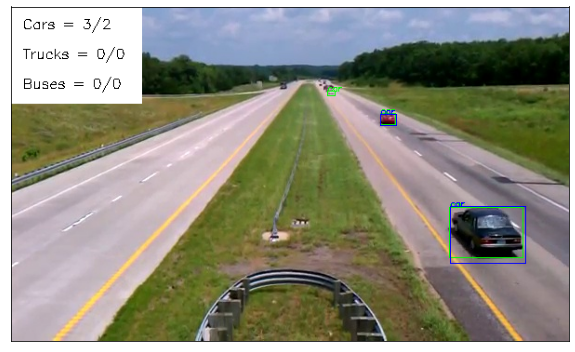

In [258]:
k = 980
frame_path = "frames/frame%d.jpg" % k
object_detection_api(frame_path, video_writer, GT_df, PRED_DF, k, rect_th=1, text_th=1, 
                     text_size=0.3, plot = True, video = False, save = True)




In [225]:
width, height

(600, 360)

In [251]:
def object_detection_api_gt(img_path, gt, count, rect_th=3, text_size=3, text_th=3, plot = False, save = False):
    GT = gt[gt.frame_number == count]
    gt_boxes = GT[['x1','y1','x2','y2']]
    gt_cls = GT['classId']
    img = cv2.imread(img_path)
    # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Convert to RGB
    for i in gt_boxes.index:
        x1 = round(gt_boxes.loc[i,'x1'])
        y1 = round(gt_boxes.loc[i,'y1'])
        x2 = round(gt_boxes.loc[i,'x2'])
        y2 = round(gt_boxes.loc[i,'y2'])
        cv2.rectangle(img, (x1,y1), (x2,y2), color=(0,0,255), thickness=rect_th)
        # Draw Rectangle with the coordinates
        cv2.putText(img, gt_cls[i], (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,255), thickness=text_th)
        # Write the prediction class
    u_g, c_g = np.unique(gt_cls,return_counts=True)
    gt_dict = dict(zip(u_g,c_g))
    if 'car' not in u_g: gt_dict['car'] = 0
    if 'truck' not in u_g: gt_dict['truck'] = 0
    if 'bus' not in u_g: gt_dict['bus'] = 0
    cv2.rectangle(img, (0,0), (140,104), color=(255, 255, 255), thickness = -1)
    cv2.putText(img, 'Cars = '+str(gt_dict['car']), (12,24), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0),thickness=1)
    cv2.putText(img, 'Trucks = '+str(gt_dict['truck']), (12,56), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0),thickness=1)
    cv2.putText(img, 'Buses = '+str(gt_dict['bus']), (12,88), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0),thickness=1)
    if plot:
        plt.figure(figsize=(10,20))
        # display the output image
        plt.imshow(img) 
        plt.xticks([]) 
        plt.yticks([]) 
        if save:
            plt.savefig('./Results/frame%d.png' % count)
        plt.show()

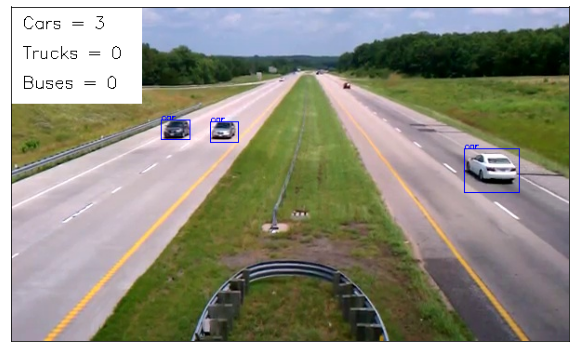

In [253]:
k = 210
frame_path = "frames/frame%d.jpg" % k
object_detection_api_gt(frame_path, GT_df, k, rect_th=1, text_th=1, 
                     text_size=0.3, plot = True, save = True)



